In [1]:
import sys
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/lee_mcc9/'
except:
    main_path = ''
sys.path.append(main_path)

In [13]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)


In [3]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

mc = uproot.open(main_path+"root_files/v17/mc_bnb.root")[fold][tree]
nc = uproot.open(main_path+"root_files/v17/nc.root")[fold][tree]
nue = uproot.open(main_path+"root_files/v17/nue.root")[fold][tree]
data = uproot.open(main_path+"root_files/v17/bnb.root")[fold][tree]
ext = uproot.open(main_path+"root_files/v17/ext.root")[fold][tree]
dirt = uproot.open(main_path+"root_files/v17/dirt.root")[fold][tree]
lee = uproot.open(main_path+"root_files/v17/nue.root")[fold][tree]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", "shr_theta_v", "shr_score_v",
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y", "trk_pfp_id",
    "shr_energy_tot", "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", "shr_dedx_y_v",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "trk_chipr_best", "trk_chipr_worst", "trk_pida", "trk_chimu", "CosmicIP", "trk_bragg_p", "trk_bragg_mu",
    "trk_bragg_mip", "shr_chipr", "shr_bragg_p", "shr_bragg_mu", "shr_chimu",
    "shr_pca_2", "shr_pca_0", "shr_pca_1", "npi0", "gamma1_edep", "gamma2_edep", "topological_score",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction"#, "crtveto", "crthitpe",
#    "_closestNuCosmicDist"
]

nue = nue.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
mc = mc.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
nc = nc.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
lee = lee.pandas.df(variables + ["weightSpline", "leeweight"], flatten=False)

ext["shr_dedx_Y"] = ext["shr_dedx_Y"] * 1.0411
data["shr_dedx_Y"] = data["shr_dedx_Y"] * 1.0411
ext["shr_dedx_Y_cali"] = ext["shr_dedx_Y_cali"] * 1.0411
data["shr_dedx_Y_cali"] = data["shr_dedx_Y_cali"] * 1.0411
ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"] * 1.0411
data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"] * 1.0411
ext["shr_dedx_y_v"] = ext["shr_dedx_y_v"] * 1.0411
data["shr_dedx_y_v"] = data["shr_dedx_y_v"] * 1.0411
ext["shr_energy_tot"] = ext["shr_energy_tot"] * 1.0411
data["shr_energy_tot"] = data["shr_energy_tot"] * 1.0411
ext["shr_energy_tot_cali"] = ext["shr_energy_tot_cali"] * 1.0411
data["shr_energy_tot_cali"] = data["shr_energy_tot_cali"] * 1.0411

lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11
nc["is_signal"] = nc["category"] == 11

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

train_nc, nc = train_test_split(nc, test_size=0.5, random_state=1990)
train_mc, mc = train_test_split(mc, test_size=0.5, random_state=1990)
train_nue, nue = train_test_split(nue, test_size=0.5, random_state=1990)
train_lee, lee = train_test_split(lee, test_size=0.5, random_state=1990)
train_ext, ext = train_test_split(ext, test_size=0.5, random_state=1990)

In [4]:
features = nue_booster.variables.copy()
features.remove("is_signal")
features.remove("nu_e")
features.remove("train_weight")
# features.remove('shr_energy_tot_cali')
# features.remove('trk_energy_tot')

for label, bkg_query in zip(nue_booster.labels, nue_booster.bkg_queries):
    with open(main_path+'pickles/booster_%s.pickle' % label, 'rb') as booster_file:
        booster = pickle.load(booster_file)
        mc[label+"_score"] = booster.predict(
            xgb.DMatrix(mc[features]),
            ntree_limit=booster.best_iteration + 1)
        nue[label+"_score"] = booster.predict(
            xgb.DMatrix(nue[features]),
            ntree_limit=booster.best_iteration + 1)
        ext[label+"_score"] = booster.predict(
            xgb.DMatrix(ext[features]),
            ntree_limit=booster.best_iteration + 1)
        data[label+"_score"] = booster.predict(
            xgb.DMatrix(data[features]),
            ntree_limit=booster.best_iteration + 1)
        dirt[label+"_score"] = booster.predict(
            xgb.DMatrix(dirt[features]),
            ntree_limit=booster.best_iteration + 1)
        lee[label+"_score"] = booster.predict(
            xgb.DMatrix(lee[features]),
            ntree_limit=booster.best_iteration + 1)
        nc[label+"_score"] = booster.predict(
            xgb.DMatrix(nc[features]),
            ntree_limit=booster.best_iteration + 1)
features = ["%s_score" % l for l in nue_booster.labels]


In [5]:
with open(main_path+'pickles/booster.pickle', 'rb') as booster_file:
    booster = pickle.load(booster_file)
    
    mc["global_score"] = booster.predict(
        xgb.DMatrix(mc[features]),
        ntree_limit=booster.best_iteration + 1)
    nue["global_score"] = booster.predict(
        xgb.DMatrix(nue[features]),
        ntree_limit=booster.best_iteration + 1)
    ext["global_score"] = booster.predict(
        xgb.DMatrix(ext[features]),
        ntree_limit=booster.best_iteration + 1)
    data["global_score"] = booster.predict(
        xgb.DMatrix(data[features]),
        ntree_limit=booster.best_iteration + 1)
    dirt["global_score"] = booster.predict(
        xgb.DMatrix(dirt[features]),
        ntree_limit=booster.best_iteration + 1)
    lee["global_score"] = booster.predict(
        xgb.DMatrix(lee[features]),
        ntree_limit=booster.best_iteration + 1)
    nc["global_score"] = booster.predict(
        xgb.DMatrix(nc[features]),
        ntree_limit=booster.best_iteration + 1)

In [6]:
genie_bins = [0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53,
       1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64,
       1.65, 1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75,
       1.76, 1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86,
       1.87, 1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97,
       1.98, 1.99, 2.  ]

genie_scaling = [12.55208645, 12.55208645, 12.55208645, 12.55208645, 12.55208645,
                 12.55208645, 12.55208645, 12.55208645, 12.55208645, 12.55208645,
                 12.55208645, 12.55208645, 12.55208645, 12.55208645,  9.31846429,
                 6.82872646,  5.80966886,  5.25531558,  4.90681853,  4.66746832,
                 4.49293156,  4.36002145,  4.25543269,  4.1709845 ,  4.10137029,
                 4.04299695,  3.99334533,  3.63941611,  3.37215618,  3.16703426,
                 3.0046366 ,  2.87287381,  2.76382446,  2.67208166,  2.59382837,
                 2.52629309,  2.46741495,  2.41562972,  2.36972839,  2.30539259,
                 2.22447092,  2.15393863,  2.09191568,  2.03694974,  1.9879012 ,
                 1.94386333,  1.90410559,  1.86803296,  1.83515574,  1.80506735,
                 1.77742741,  1.75194873,  1.72135465,  1.69270839,  1.66611657,
                 1.64136581,  1.61827132,  1.59667225,  1.57642789,  1.55741465,
                 1.53952355,  1.52265813,  1.5067326 ,  1.49167054,  1.47724254,
                 1.4633238 ,  1.45005827,  1.43740101,  1.42531113,  1.41375132,
                 1.40268744,  1.39208829,  1.38192516,  1.3721717 ,  1.36280362,
                 1.35379853,  1.34513573,  1.3382099 ,  1.33160516,  1.32520344,
                 1.31899554,  1.31297275,  1.30712695,  1.30145044,  1.29593597,
                 1.2905767 ,  1.28536616,  1.28029826,  1.2753672 ,  1.27093091,
                 1.2670996 ,  1.26335684,  1.25969956,  1.25612491,  1.25263008,
                 1.24921247,  1.24586951,  1.24259879,  1.23939799,  1.23626491,
                 1.23319741,  1.23019345,  1.22864381,  1.2272612 ,  1.22590205,
                 1.2245658 ,  1.22325186,  1.22195966,  1.22068869,  1.21943842,
                 1.21820836,  1.21699801,  1.2158069 ,  1.21463458,  1.21351191,
                 1.21245322,  1.21140978,  1.2103813 ,  1.20936743,  1.20836788,
                 1.20738232,  1.20641049,  1.2054521 ,  1.20450685,  1.20357449,
                 1.20265476,  1.20174739,  1.20052184,  1.19926979,  1.19803419,
                 1.19681469,  1.19561103,  1.19442285,  1.19324989,  1.19209183,
                 1.19094842,  1.18981934,  1.18870437,  1.18760322,  1.18631829,
                 1.1847203 ,  1.18314236,  1.18158407,  1.18004508,  1.17852505,
                 1.1770236 ,  1.1755404 ,  1.17407513,  1.17262746,  1.17119709,
                 1.16978368,  1.16838696,  1.16714401,  1.16593671,  1.16474264,
                 1.16356158,  1.16239332,  1.16123766,  1.16009438,  1.15896329,
                 1.1578442 ,  1.15673692,  1.15564126,  1.15455704,  1.15331053,
                 1.1517574 ,  1.15022124,  1.14870176,  1.14719869,  1.14571179,
                 1.14424076,  1.14278538,  1.14134538,  1.13992053,  1.13851058,
                 1.13711532,  1.1357345 ,  1.13452556,  1.13335865,  1.13220312,
                 1.13105879,  1.12992553,  1.12880314,  1.12769148,  1.12659041,
                 1.12549978,  1.12441941,  1.12334919,  1.12228896,  1.12127696,
                 1.12035283,  1.11943726,  1.11853014,  1.11763134,  1.11674075,
                 1.11585826,  1.11498376,  1.11411714,  1.11325829,  1.11240711,
                 1.11156352]

# nc["genie_weight"] = 1
# nue["genie_weight"] = 1
# mc["genie_weight"] = 1
# dirt["genie_weight"] = 1
# lee["genie_weight"] = 1

# for i, genie_bin in enumerate(genie_bins):
    
#     if i == 0:
#         continue
        
#     nue.loc[(nue['nu_e'] > genie_bins[i-1]) & (nue['nu_e'] < genie_bins[i]), 'weightSpline'] = genie_scaling[i-1]
#     mc.loc[(mc['nu_e'] > genie_bins[i-1]) & (mc['nu_e'] < genie_bins[i]), 'weightSpline'] = genie_scaling[i-1]
#     dirt.loc[(dirt['nu_e'] > genie_bins[i-1]) & (dirt['nu_e'] < genie_bins[i]), 'weightSpline'] = genie_scaling[i-1]
#     nc.loc[(nc['nu_e'] > genie_bins[i-1]) & (nc['nu_e'] < genie_bins[i]), 'weightSpline'] = genie_scaling[i-1]
#     lee.loc[(lee['nu_e'] > genie_bins[i-1]) & (lee['nu_e'] < genie_bins[i]), 'weightSpline'] = genie_scaling[i-1]


In [14]:
lee["reco_e"] = (lee["shr_energy_tot_cali"] + 0.030) / 0.79 + lee["trk_energy_tot"]
data["reco_e"] = (data["shr_energy_tot_cali"] + 0.030) / 0.79 + data["trk_energy_tot"]
nue["reco_e"] = (nue["shr_energy_tot_cali"] + 0.030) / 0.79 + nue["trk_energy_tot"]
mc["reco_e"] = (mc["shr_energy_tot_cali"] + 0.030) / 0.79 + mc["trk_energy_tot"]
dirt["reco_e"] = (dirt["shr_energy_tot_cali"] + 0.030) / 0.79 + dirt["trk_energy_tot"]
ext["reco_e"] = (ext["shr_energy_tot_cali"] + 0.030) / 0.79 + ext["trk_energy_tot"]
nc["reco_e"] = (nc["shr_energy_tot_cali"] + 0.030) / 0.79 + nc["trk_energy_tot"]

# nue["weightSpline"] = 1
# mc["weightSpline"] = 1
# dirt["weightSpline"] = 1
# lee["weightSpline"] = 1

samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext,
    "dirt": dirt,
    "nc": nc,
    "lee": lee
}

scaling = 1#132.0/4.5

weights = {
    "mc": 0.040061 * 2 * scaling,
    "nue": 0.0004442 * 2 * scaling,
    "ext": 0.34689 * 2 * scaling,
    "dirt": 0.491684 * scaling,
    "lee": 0.0004442 * 2 * scaling,
    "nc": 0.017826 * 2 * scaling,
}


# weights = {
#     "mc": 0.0213430 * 2 * scaling,
#     "nue": 0.00009729 * 2 * scaling,
#     "ext": 0.19003 * 2 * scaling,
#     "dirt": 0.491684 * scaling,
#     "lee": 0.00009729 * 2 * scaling,
# #     "nc": 0.017604 * 2 * scaling,
# }



my_plotter = plotter.Plotter(samples, weights, pot=4.5e19)

Profile likelihood: 2.67 sigma @ 1.32e21 POT
s/sqrt(b): 1.09 sigma @ 1.32e21 POT


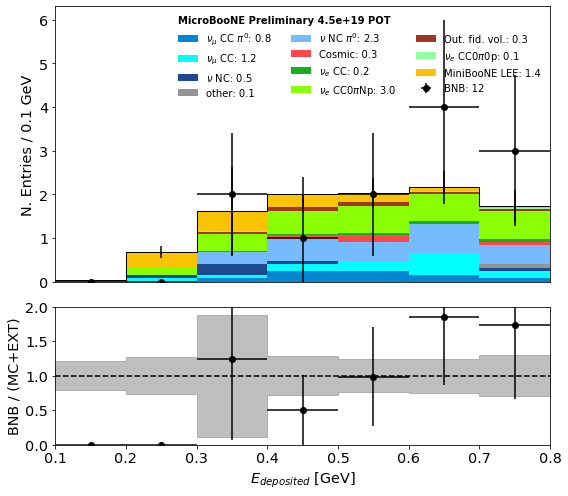

In [15]:
miniboone_bins = [
    0, 0.200, 0.300, 0.375, 0.475, 0.550, 0.675, 0.800, 0.950, 1.100, 1.300,
    1.500, 3.000
]

# score_cut = 0.9995
score_cut = 0.997

# print(samples["data"].query("selected==1 & global_score > %g & reco_e >0.8" % score_cut)[["run", "sub", "evt"]].to_string(index=False))

fig, ax1, ax2 = my_plotter.plot_variable(
    "reco_e",
#     query="trk_chipr > 0 & hits_y > 100 & trk_chipr < 80 & hits_ratio > 0.75 & selected==1 & shr_energy/shr_energy_tot > 0.8 & shr_distance < 5 & trk_distance < 5 & slpdg==12 & (shr_energy_tot+0.02)/0.8 > 0.06 & shr_tkfit_dedx_Y < 3.5 & shr_tkfit_dedx_Y > 0.5",
    query="selected==1 & global_score > %g" % score_cut,
#     query="selected==1",
    kind="event_category",
    draw_sys=True,
    title=r"$E_{deposited}$ [GeV]",
#     bins=miniboone_bins,
    bins=7,
    range=(0.1,0.8),
)

# ax1.axvline(x=score_cut, color="k", linestyle='--')
# print(samples["mc"].query("selected==1 & global_score > %g & reco_e > 0.2 & reco_e < 0.8 & category != 11" % score_cut)[["run","sub","evt","shr_score", "category", "trk_chipr"]])

print("Profile likelihood: %.2f sigma @ 1.32e21 POT" % my_plotter.significance_likelihood)
print("s/sqrt(b): %.2f sigma @ 1.32e21 POT" % my_plotter.significance)

# ax1.set_ylim(0,450)
# ax1.set_yscale("log")
# ax1.set_ylim(0,1)
fig.savefig(main_path+"plots/spectrum.pdf")

[0.24254413 0.18816467 0.1621125  0.13237225 0.13578884 0.14350585
 0.14143849]


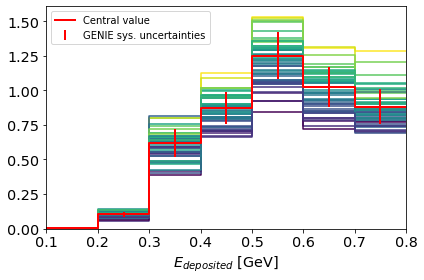

In [74]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import matplotlib.pyplot as plt

x_range = (0.1,0.8)
n_bins = 7

n_tot = np.empty([50, n_bins])
n_cv_tot = np.empty(n_bins)
n_tot.fill(0)
n_cv_tot.fill(0)
score_cut = 0.997

my_cmap = cm.get_cmap('viridis')

for t in samples:
    if t in ["ext", "data", "lee"]:
        continue
    tree = samples[t]
    
    extra_query = ""
    if t == "mc":
        extra_query = "& ~(nu_pdg == 12 & ccnc == 0) & ~(npi0 != 0 & ccnc == 1)"
        
    queried_tree = tree.query("selected==1 & global_score > %g %s & interaction == 1" % (score_cut, extra_query))
    variable = queried_tree["reco_e"]
    genie_weights = queried_tree["weightsGenie"]
    spline_fix = queried_tree["weightSpline"]*weights[t]

    s = genie_weights
    df = pd.DataFrame(s.values.tolist())


    n_cv, bins = np.histogram(
        variable,
        range=x_range,
        bins=n_bins,
        weights=spline_fix)
    
    n_cv_tot += n_cv

    if not df.empty:
        for i in range(50):
            weight = df[i].values
            weight[np.isnan(weight)] = 1
            weight[weight > 100] = 1

            n, bins = np.histogram(
                variable, weights=weight*spline_fix, range=x_range, bins=n_bins)

            n_tot[i] += n

        
bincenters = 0.5 * (bins[1:] + bins[:-1])

left,right = bins[:-1],bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([n_cv_tot,n_cv_tot]).T.flatten()
plt.plot(X,Y,color='r',linewidth=2,label='Central value')

    
cov = np.empty([len(n_cv), len(n_cv)])
cov.fill(0)

my_norm = Normalize(vmin=min((sum(n) for n in n_tot)), vmax=max((sum(n) for n in n_tot)))

for n in n_tot:
    left,right = bins[:-1],bins[1:]
    X = np.array([left,right]).T.flatten()
    Y = np.array([n,n]).T.flatten()
    plt.plot(X,Y,color=my_cmap(my_norm(sum(n))),zorder=-32)
    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

cov /= 50
            
frac_cov = np.empty([len(n_cv), len(n_cv)])
corr = np.empty([len(n_cv), len(n_cv)])

for i in range(len(n_cv)):
    for j in range(len(n_cv)):
        frac_cov[i][j] = cov[i][j] / (n_cv_tot[i] * n_cv_tot[j])
        corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])

        
plt.errorbar(
    bincenters, 
    n_cv_tot,
    yerr=np.sqrt(np.diag(cov)), 
    fmt='none', 
    ecolor='r',
    linewidth=2,
    label='GENIE sys. uncertainties')

print(np.sqrt(np.diag(cov))/n_cv_tot)
plt.xlim(x_range[0], x_range[1])
plt.xlabel(r"$E_{deposited}$ [GeV]")
plt.legend()
plt.ylim(ymin=0)
plt.tight_layout()
plt.savefig("plots/spec.pdf", transparent=True)

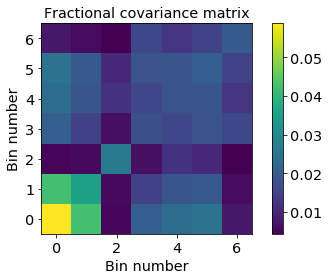

In [86]:
fig, ax = plt.subplots(1, 1)
pos = ax.imshow(frac_cov, origin='lower', cmap='viridis')
ax.set_title("Fractional covariance matrix")
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)
fig.tight_layout()
fig.savefig("plots/frac.pdf", transparent=True)

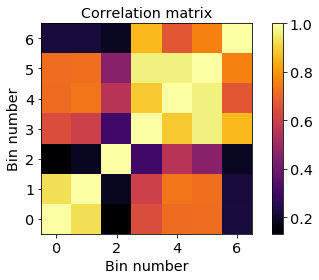

In [83]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Correlation matrix")
pos = ax.imshow(corr, origin='lower', cmap='inferno')
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)
fig.tight_layout()
fig.savefig("plots/corr.pdf", transparent=True)

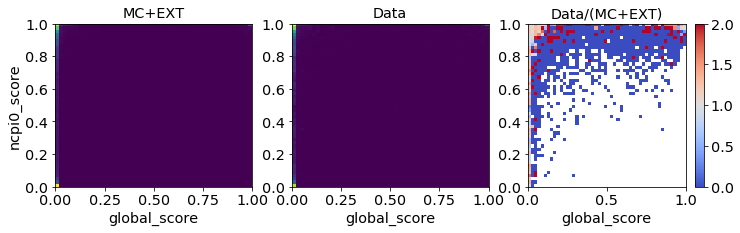

In [12]:
my_plotter.plot_2d(
    "global_score",
    "ncpi0_score",
    query="selected==1",
    bins_x=50,
    bins_y=50,
    range_x=(0., 1),
    range_y=(0., 1))